# Drift validation

In [14]:
import iris
import numpy
import matplotlib.pyplot as plt
import glob

import pandas as pd
from bokeh.charts import TimeSeries, show, output_file

from iris.experimental.equalise_cubes import equalise_attributes

### Read data

In [15]:
institution = 'NOAA-GFDL'
model = 'GFDL-CM3'
control_location = '/g/data/ua6'  # /g/data/r87/dbi599
historical_location = '/g/data/ua6'

In [16]:
control_files = glob.glob('%s/drstree/CMIP5/GCM/%s/%s/piControl/mon/ocean/thetao/r1i1p1/thetao_Omon_%s_piControl_r1i1p1_*.nc' %(control_location, institution, model, model) )
historical_files = glob.glob('%s/drstree/CMIP5/GCM/%s/%s/historical/mon/ocean/thetao/r1i1p1/thetao_Omon_%s_historical_r1i1p1_*.nc' %(historical_location, institution, model, model) )
dedrifted_historical_files = glob.glob('/g/data/r87/dbi599/drstree/CMIP5/GCM/%s/%s/historical/mon/ocean/thetao/r1i1p1/dedrifted/thetao_Omon_%s_historical_r1i1p1_*.nc' %(institution, model, model) )
coefficient_file = '/g/data/r87/dbi599/drstree/CMIP5/GCM/%s/%s/piControl/mon/ocean/thetao/r1i1p1/thetao-coefficients_Omon_%s_piControl_r1i1p1_all.nc' %(institution, model, model)

In [49]:
# Set constraints
#min_lat, max_lat = [-62.1, -60.9]
#lat_subset = lambda cell: min_lat <= cell <= max_lat
lev_constraint = iris.Constraint(depth=15)
lat_constraint = iris.Constraint(grid_latitude=-63.5)
lon_constraint = iris.Constraint(grid_longitude=70.5)

In [55]:
def read_files(file_list):
    """Read a list of files into an iris Cube"""
    
    cube = iris.load(file_list, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)
    equalise_attributes(cube)
    cube = cube.concatenate_cube()
    
    return cube

In [77]:
control_cube = read_files(control_files)
historical_cube = read_files(historical_files)
dedrifted_historical_cube = read_files(dedrifted_historical_files)
coefficient_cube = iris.load_cube(coefficient_file, 'Sea Water Potential Temperature' & lev_constraint & lat_constraint & lon_constraint)

In [78]:
print control_cube

sea_water_potential_temperature / (K) (time: 6000)
     Dimension coordinates:
          time                             x
     Scalar coordinates:
          depth: 15.0 m, bound=(10.0, 20.0) m
          grid_latitude: -63.5 degrees
          grid_longitude: 70.5 degrees
          latitude: -63.5 degrees, bound=(-64.0, -64.0, -63.0, -63.0) degrees
          longitude: 70.5 degrees, bound=(70.0, 71.0, 71.0, 70.0) degrees
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_GFDL-CM3_piControl_r0i0p0.nc...
          branch_time: 0.0
          comment: GFDL experiment name: CM3Z_Control-1860_D1
GFDL parent experiment name:...
          comments: Note: This model output is presented on the model's tripolar grid. The...
          contact: gfdl.climate.model.info@noaa.gov
          experiment: pre-industrial control
          experiment_id: piControl
          forcing: N/A
          f

In [79]:
print coefficient_cube

Sea Water Potential Temperature / (1) (drift coefficient: 4)
     Dimension coordinates:
          drift coefficient                             x
     Scalar coordinates:
          depth: 15.0 m, bound=(10.0, 20.0) m
          grid_latitude: -63.5 degrees
          grid_longitude: 70.5 degrees
          latitude: -63.5 degrees, bound=(-64.0, -64.0, -63.0, -63.0) degrees
          longitude: 70.5 degrees, bound=(70.0, 71.0, 71.0, 70.0) degrees
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_GFDL-CM3_piControl_r0i0p0.nc...
          branch_time: 0.0
          comment: GFDL experiment name: CM3Z_Control-1860_D1
GFDL parent experiment name:...
          comments: Note: This model output is presented on the model's tripolar grid. The...
          contact: gfdl.climate.model.info@noaa.gov
          creation_date: 2011-10-12T00:44:11Z
          experiment: pre-industrial control


In [81]:
print coefficient_cube.data

[  2.74396027e+02  -1.92017706e-05   3.36148942e-10  -1.17815200e-15]


### Validate polynomial contruction

In [82]:
def apply_polynomial(x, a, b, c, d):
    """Evaluate cubic polynomial.

    The axis argument is not used but is required for the function to be 
      used with numpy.apply_over_axes 

    """

    result = a + b * x + c * x**2 + d * x**3 
    
    return result 

In [84]:
coeff_a, coeff_b, coeff_c, coeff_d = coefficient_cube.data
my_poly = apply_polynomial(control_cube.coord('time').points,
                           coeff_a, coeff_b, coeff_c, coeff_d)

In [85]:
print my_poly[0:5]

[ 274.39572906  274.39516321  274.39459794  274.39401413  274.39343094]


In [86]:
numpy_poly = numpy.poly1d([float(coeff_d), 
                           float(coeff_c),
                           float(coeff_b),
                           float(coeff_a)])

In [87]:
print numpy_poly(control_cube.coord('time').points)[0:5]

[ 274.39572906  274.39516321  274.39459794  274.39401413  274.39343094]


In [88]:
print control_cube.data[0:5]

[ 277.2671814   277.78060913  276.54486084  274.93106079  273.25476074]


### Plot

In [ ]:
control_times = control_cube.coord('time').points
df = pd.DataFrame(control_cube.data, index=control_times, columns=['control'])





data = dict(AAPL=AAPL['Adj Close'], Date=AAPL['Date'])


In [ ]:
output_file("timeseries.html")

data = dict(AAPL=AAPL['Adj Close'], Date=AAPL['Date'])

p = TimeSeries(data, index='Date', title="APPL", ylabel='Stock Prices')

show(p)

In [15]:
% matplotlib inline

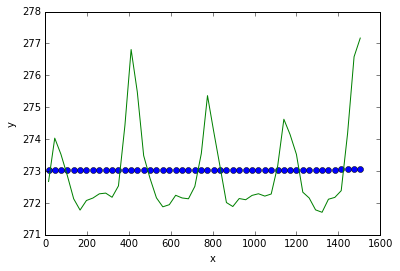

In [16]:
plt.plot(full_control_cube.coord('time').points[0:50], my_poly[0:50], 'o')
plt.plot(control_cube.coord('time').points[0:50], control_cube.data[0:50])
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [17]:
print coeff_a_cube.data

print my_poly[950:960]

273.036007766
[ 273.24665794  273.24684012  273.24702222  273.24720424  273.24738617
  273.24757101  273.24775278  273.24793447  273.24811608  273.2482976 ]


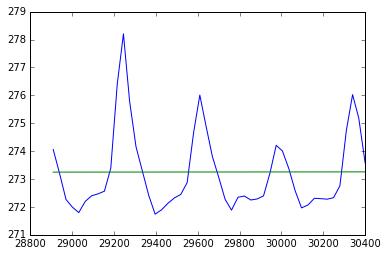

In [18]:
plt.plot(full_control_cube.coord('time').points[950:1000], full_control_cube.data[950:1000], 'b-')
plt.plot(full_control_cube.coord('time').points[950:1000], my_poly[950:1000], 'g-')
plt.show()

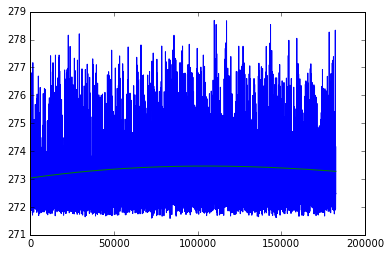

In [19]:
plt.plot(full_control_cube.coord('time').points, full_control_cube.data, 'b-')
plt.plot(full_control_cube.coord('time').points, my_poly, 'g-')
plt.show()

## Validate removal from historical

In [20]:
print hist_cube.coord('time').points[0:5]
print dedrift_cube.coord('time').points[0:5]

[  15.5   45.    74.5  105.   135.5]
[  15.5   45.    74.5  105.   135.5]


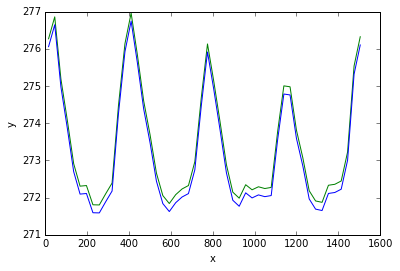

In [21]:
plt.plot(hist_cube.coord('time').points[0:50], hist_cube.data[0:50], 'g-')
plt.plot(dedrift_cube.coord('time').points[0:50], dedrift_cube.data[0:50], 'b-')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [22]:
hist_cube.attributes['branch_time']

29200.0

In [23]:
control_time_axis = list(full_control_cube.coord('time').points)
print len(control_time_axis)
print control_time_axis[959:965]
print control_time_axis.index(29184.5)

6000
[29184.5, 29215.5, 29245.0, 29274.5, 29305.0, 29335.5]
959


In [26]:
print hist_cube.data[25]
print dedrift_cube.data[25]
print hist_cube.data[25] - dedrift_cube.data[25]
print my_poly[959 + 25] - float(coeff_a_cube.data)

276.13
275.913313571
0.216965970111
0.216792454811
